# New York City Taxi Trip Duration

https://www.kaggle.com/c/nyc-taxi-trip-duration

In this competition, Kaggle is challenging you to build a model that predicts the total ride duration of taxi trips in New York City. Your primary dataset is one released by the NYC Taxi and Limousine Commission, which includes pickup time, geo-coordinates, number of passengers, and several other variables.

### Data Description
The competition dataset is based on the 2016 NYC Yellow Cab trip record data made available in Big Query on Google Cloud Platform. The data was originally published by the NYC Taxi and Limousine Commission (TLC). The data was sampled and cleaned for the purposes of this playground competition. Based on individual trip attributes, participants should predict the duration of each trip in the test set.

### File descriptions
* train.csv - the training set (contains 1458644 trip records)
* test.csv - the testing set (contains 625134 trip records)
* sample_submission.csv - a sample submission file in the correct format

### Data fields
* id - a unique identifier for each trip
* vendor_id - a code indicating the provider associated with the trip record
* pickup_datetime - date and time when the meter was engaged
* dropoff_datetime - date and time when the meter was disengaged
* passenger_count - the number of passengers in the vehicle (driver entered value)
* pickup_longitude - the longitude where the meter was engaged
* pickup_latitude - the latitude where the meter was engaged
* dropoff_longitude - the longitude where the meter was disengaged
* dropoff_latitude - the latitude where the meter was disengaged
* store_and_fwd_flag - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server - Y=store and forward; N=not a store and forward trip
* trip_duration - duration of the trip in seconds

In [3]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.grid_search import GridSearchCV
import xgboost
%matplotlib inline


plt.rcParams['figure.figsize']=[16,10]

read training and test

In [56]:
df_train = pd.read_csv('train.csv')

In [8]:
df_test = pd.read_csv('test.csv')

Check data

In [9]:
df_train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


## Data Preprocessing

Checking the distribution


In [16]:
df_train['log_trip_duration'] = np.log(df_train['trip_duration'].values+1)

<function matplotlib.pyplot.show(*args, **kw)>

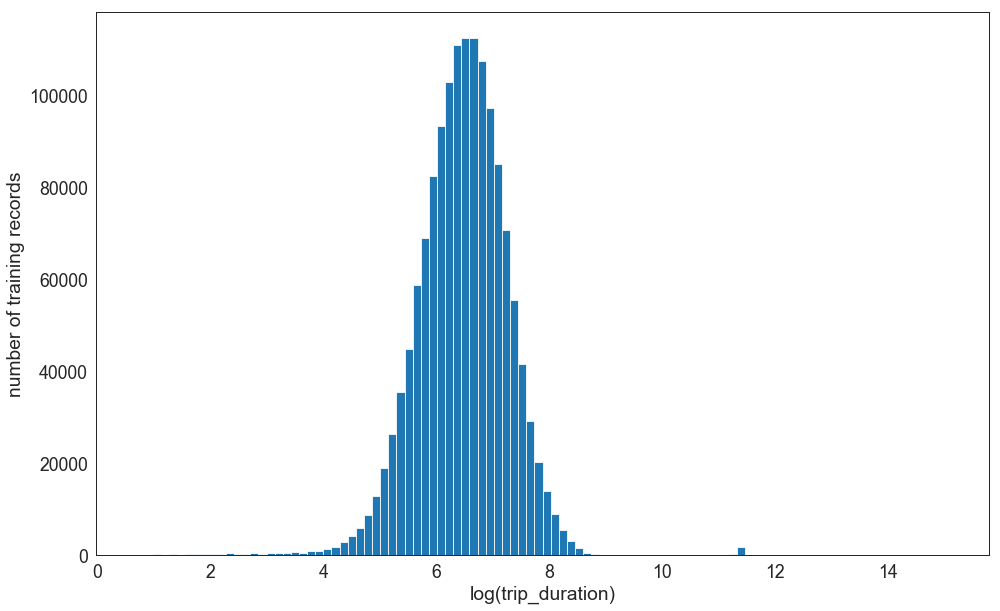

In [18]:
plt.hist(df_train['log_trip_duration'].values, bins=100)
plt.xlabel('log(trip_duration)')
plt.ylabel('number of training records')
plt.show

Plot all the pickup longitude and latitude. This would give an awesome visualization of manhatten

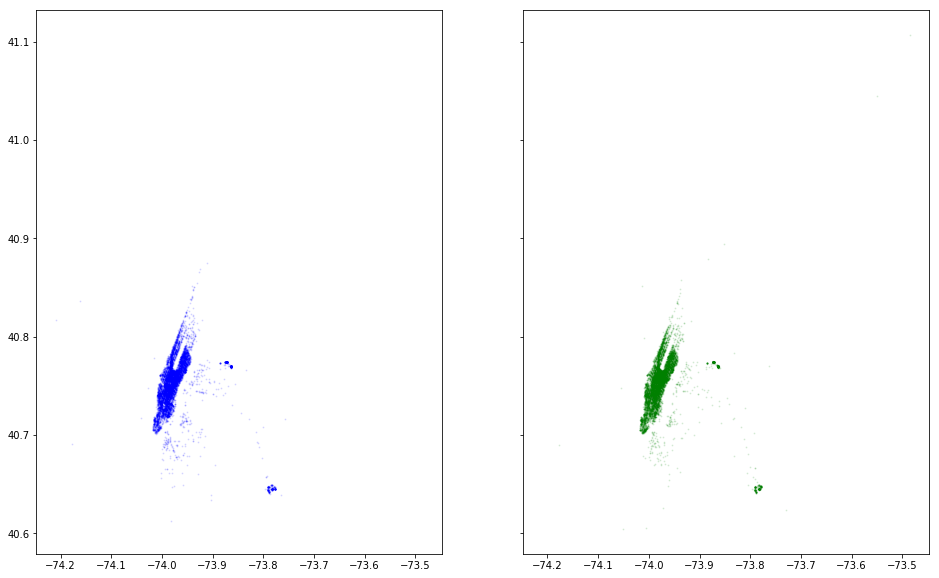

In [10]:
N = 10000
city_long_border =(-75, -75)
city_lat_border=(40,40)
fig, ax = plt.subplots(ncols=2, sharex=True, sharey=True)
ax[0].scatter(df_train['pickup_longitude'].values[:N],
             df_train['pickup_latitude'].values[:N],
             color='blue',s=1,label='train data', alpha=0.1)
ax[1].scatter(df_test['pickup_longitude'].values[:N],
             df_test['pickup_latitude'].values[:N],
             color='green',s=1,label='test data', alpha=0.1)

plt.show()

Converting the type

In [57]:
df_train.passenger_count = df_train.passenger_count.astype(np.uint8)
df_train.vendor_id = df_train.vendor_id.astype(np.uint8)
df_train.trip_duration = df_train.trip_duration.astype(np.uint32)

In [58]:
df_train.shape

(1458644, 11)

In [59]:
df_train.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06
mean,1.534950e+00,1.664530e+00,-7.397349e+01,4.075092e+01,-7.397342e+01,4.075180e+01,9.594923e+02
std,4.987772e-01,1.314242e+00,7.090186e-02,3.288119e-02,7.064327e-02,3.589056e-02,5.237432e+03
min,1.000000e+00,0.000000e+00,-1.219333e+02,3.435970e+01,-1.219333e+02,3.218114e+01,1.000000e+00
25%,1.000000e+00,1.000000e+00,-7.399187e+01,4.073735e+01,-7.399133e+01,4.073588e+01,3.970000e+02
50%,2.000000e+00,1.000000e+00,-7.398174e+01,4.075410e+01,-7.397975e+01,4.075452e+01,6.620000e+02
75%,2.000000e+00,2.000000e+00,-7.396733e+01,4.076836e+01,-7.396301e+01,4.076981e+01,1.075000e+03
max,2.000000e+00,9.000000e+00,-6.133553e+01,5.188108e+01,-6.133553e+01,4.392103e+01,3.526282e+06


In [60]:
for c in [c for c in df_train.columns if c.endswith('tude')]:
    df_train.loc[:,c] = df_train[c].astype(np.float32)

In [61]:
df_train.pickup_datetime=pd.to_datetime(df_train.pickup_datetime)
df_train.dropoff_datetime=pd.to_datetime(df_train.dropoff_datetime)

In [62]:
df_train['pu_hour'] = df_train.pickup_datetime.dt.hour
df_train['yday'] = df_train.pickup_datetime.dt.dayofyear
df_train['wday'] = df_train.pickup_datetime.dt.dayofweek
df_train['month'] = df_train.pickup_datetime.dt.month

Checking correlation of features

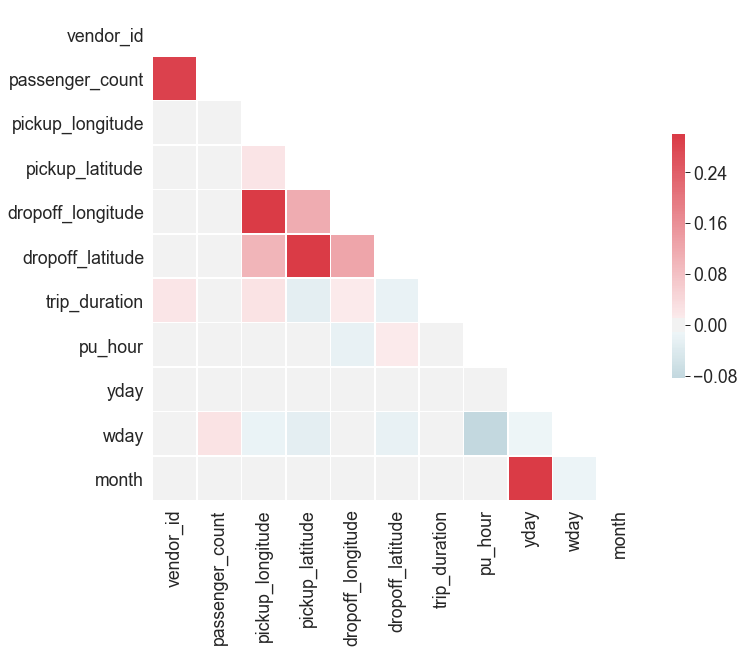

In [63]:
sns.set_style('white')
sns.set_context("paper",font_scale=2)
corr = df_train.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(11,9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=0.3, center=0,
           square=True, linewidths=0.5, cbar_kws={"shrink":0.5})

Checking the trip duration distribution

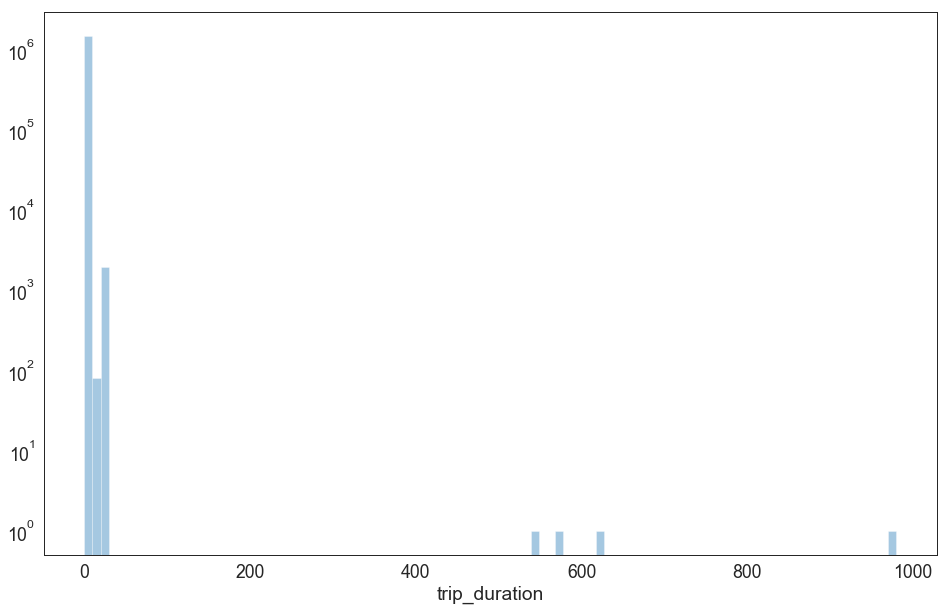

In [64]:
fig, ax = plt.subplots(ncols=1, nrows=1)
sns.distplot(df_train['trip_duration']/3600,ax=ax,bins=100,kde=False,hist_kws={'log':True})

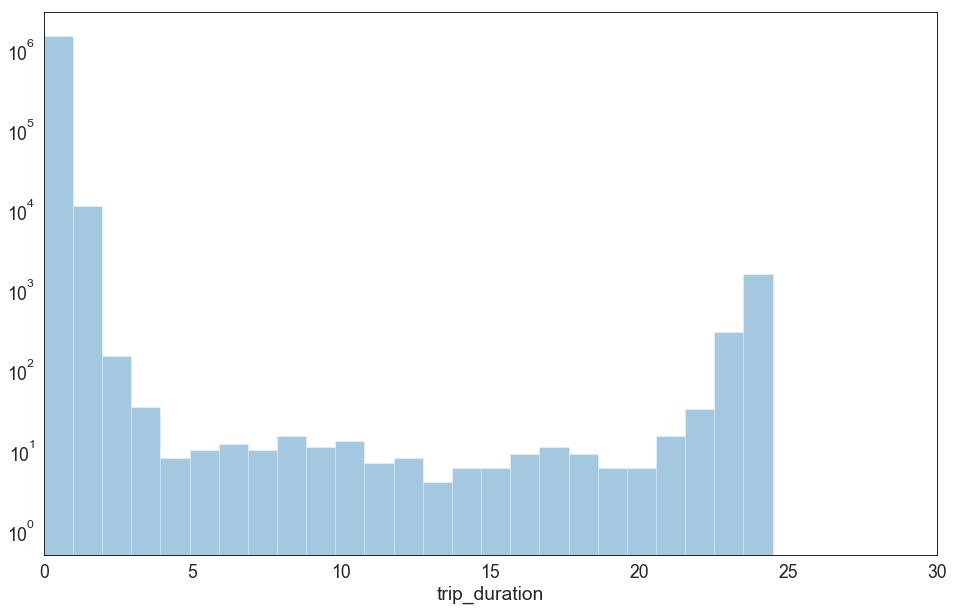

In [65]:
fig, ax = plt.subplots(ncols=1, nrows=1)
ax.set_xlim(0,30)
sns.distplot(df_train['trip_duration']/3600,ax=ax,bins=1000,kde=False,hist_kws={'log':True})

Distance calculation

In [66]:
def haversine(lon1, lat1, lon2, lat2):

    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    miles = km *  0.621371
    return miles

In [67]:
df_train['distance'] = haversine(df_train.pickup_longitude, df_train.pickup_latitude,
                                           df_train.dropoff_longitude, df_train.dropoff_latitude)

weather data picked up from https://www.kaggle.com/mathijs/weather-data-in-new-york-city-2016

In [68]:
wdf = pd.read_csv('weather_data_nyc_centralpark_2016.csv')

In [69]:
wdf['date']=pd.to_datetime(wdf.date,format='%d-%m-%Y')
wdf['yday'] = wdf.date.dt.dayofyear

In [70]:
wdf.head()

,date,maximum temperature,minimum temperature,average temperature,precipitation,snow fall,snow depth,yday
0,2016-01-01,42,34,38.0,0.00,0.0,0,1
1,2016-01-02,40,32,36.0,0.00,0.0,0,2
2,2016-01-03,45,35,40.0,0.00,0.0,0,3
3,2016-01-04,36,14,25.0,0.00,0.0,0,4
4,2016-01-05,29,11,20.0,0.00,0.0,0,5


In [71]:
wdf['snowfall'] = wdf['snow fall'].replace(['T'],0.05).astype(np.float32)
wdf['precipitation'] = wdf['precipitation'].replace(['T'],0.05).astype(np.float32)
wdf['snowdepth'] = wdf['snow depth'].replace(['T'],0.05).astype(np.float32)

merging on dayofyear

In [72]:
df_train = pd.merge(df_train,wdf,on='yday')

In [73]:
wdf.head()

,date,maximum temperature,minimum temperature,average temperature,precipitation,snow fall,snow depth,yday,snowfall,snowdepth
0,2016-01-01,42,34,38.0,0.0,0.0,0,1,0.0,0.0
1,2016-01-02,40,32,36.0,0.0,0.0,0,2,0.0,0.0
2,2016-01-03,45,35,40.0,0.0,0.0,0,3,0.0,0.0
3,2016-01-04,36,14,25.0,0.0,0.0,0,4,0.0,0.0
4,2016-01-05,29,11,20.0,0.0,0.0,0,5,0.0,0.0


In [74]:
df_train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,distance,date,maximum temperature,minimum temperature,average temperature,precipitation,snow fall,snow depth,snowfall,snowdepth
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,...,0.930648,2016-03-14,51,40,45.5,0.29,0.0,0,0.0,0.0
1,id2129090,1,2016-03-14 14:05:39,2016-03-14 14:28:05,1,-73.975090,40.758766,-73.953201,40.765068,N,...,1.224526,2016-03-14,51,40,45.5,0.29,0.0,0,0.0,0.0
2,id0256505,1,2016-03-14 15:04:38,2016-03-14 15:16:13,1,-73.994484,40.745087,-73.998993,40.722710,N,...,1.563173,2016-03-14,51,40,45.5,0.29,0.0,0,0.0,0.0
3,id3863815,2,2016-03-14 04:24:36,2016-03-14 04:37:11,3,-73.944359,40.714489,-73.910530,40.709492,N,...,1.803944,2016-03-14,51,40,45.5,0.29,0.0,0,0.0,0.0
4,id3817493,2,2016-03-14 14:57:56,2016-03-14 15:15:26,1,-73.952881,40.766468,-73.978630,40.761921,N,...,1.382826,2016-03-14,51,40,45.5,0.29,0.0,0,0.0,0.0


In [75]:
df_train = df_train.drop(['date','maximum temperature','minimum temperature'],axis=1)

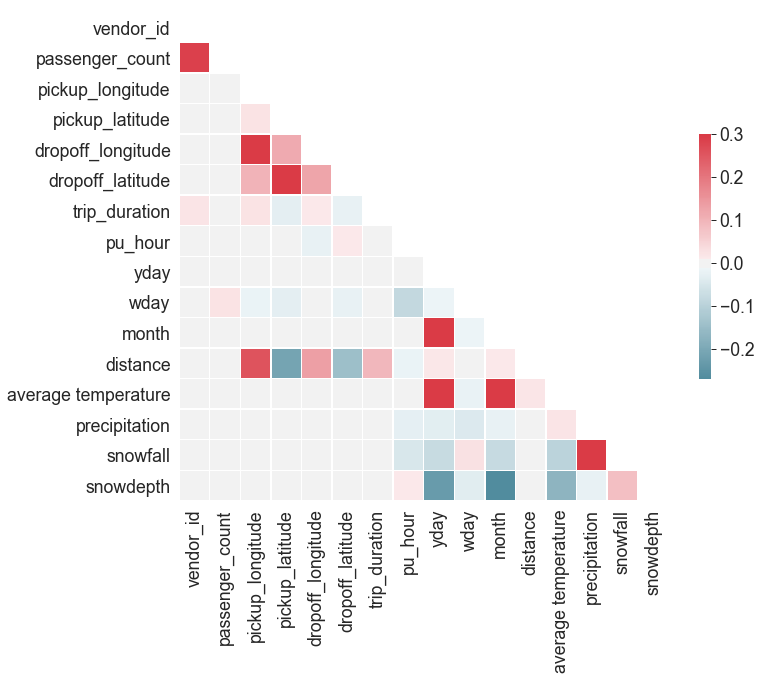

In [76]:
sns.set_style('white')
sns.set_context("paper",font_scale=2)
corr = df_train.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(11,9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=0.3, center=0,
           square=True, linewidths=0.5, cbar_kws={"shrink":0.5})

In [77]:
corr

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,pu_hour,yday,wday,month,distance,average temperature,precipitation,snowfall,snowdepth
vendor_id,1.000000,0.287415,0.007820,0.001742,0.001528,0.004496,0.020304,0.009299,-0.006025,0.001311,-0.006221,0.008109,-0.005760,0.001385,0.000207,0.006036
passenger_count,0.287415,1.000000,0.002169,-0.005125,-0.000343,-0.002762,0.008471,0.009101,-0.001784,0.025191,-0.002143,0.010306,-0.001203,0.001415,0.000510,0.000733
pickup_longitude,0.007820,0.002169,1.000000,0.022568,0.783582,0.100190,0.026542,0.010150,0.004263,-0.016356,0.004474,0.259780,0.005547,0.001418,-0.003288,0.003602
pickup_latitude,0.001742,-0.005125,0.022568,1.000000,0.114884,0.494038,-0.029204,0.010603,-0.002516,-0.028976,-0.001439,-0.210354,-0.002011,-0.004180,-0.005058,-0.000112
dropoff_longitude,0.001528,-0.000343,0.783582,0.114884,1.000000,0.124873,0.014678,-0.022455,0.004612,-0.001130,0.004758,0.134033,0.005502,0.001660,0.000774,0.001092
dropoff_latitude,0.004496,-0.002762,0.100190,0.494038,0.124873,1.000000,-0.020677,0.013612,-0.001554,-0.021762,-0.000607,-0.142128,-0.000997,-0.002710,-0.002434,0.000454
trip_duration,0.020304,0.008471,0.026542,-0.029204,0.014678,-0.020677,1.000000,0.003690,0.006625,-0.000708,0.006607,0.094777,0.004574,-0.002590,-0.000190,0.002716
pu_hour,0.009299,0.009101,0.010150,0.010603,-0.022455,0.013612,0.003690,1.000000,-0.003340,-0.084255,-0.003438,-0.015813,-0.004948,-0.028656,-0.048589,0.014215
yday,-0.006025,-0.001784,0.004263,-0.002516,0.004612,-0.001554,0.006625,-0.003340,1.000000,-0.013615,0.985657,0.016443,0.837212,-0.031407,-0.077248,-0.229351
wday,0.001311,0.025191,-0.016356,-0.028976,-0.001130,-0.021762,-0.000708,-0.084255,-0.013615,1.000000,-0.014544,0.007599,-0.019799,-0.041673,0.028427,-0.034647


fastest route data got from https://www.kaggle.com/oscarleo/new-york-city-taxi-with-osrm 

In [78]:
fastest1 = pd.read_csv('fastest_routes_train_part_1.csv')
fastest2 = pd.read_csv('fastest_routes_train_part_2.csv')
fastest = pd.concat([fastest1,fastest2],ignore_index=True)
fastest = fastest.drop(['step_location_list','step_direction','step_maneuvers','travel_time_per_step','distance_per_step','street_for_each_step','number_of_steps','starting_street','end_street'],axis=1)
fastest.head() #

,id,total_distance,total_travel_time
0,id2875421,2009.1,164.9
1,id2377394,2513.2,332.0
2,id3504673,1779.4,235.8
3,id2181028,1614.9,140.1
4,id0801584,1393.5,189.4


merge the ride on id

In [79]:
df_train = pd.merge(df_train,fastest,on='id',how='outer')
df_train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,month,distance,average temperature,precipitation,snow fall,snow depth,snowfall,snowdepth,total_distance,total_travel_time
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,...,3,0.930648,45.5,0.29,0.0,0,0.0,0.0,2009.1,164.9
1,id2129090,1,2016-03-14 14:05:39,2016-03-14 14:28:05,1,-73.975090,40.758766,-73.953201,40.765068,N,...,3,1.224526,45.5,0.29,0.0,0,0.0,0.0,2782.9,244.6
2,id0256505,1,2016-03-14 15:04:38,2016-03-14 15:16:13,1,-73.994484,40.745087,-73.998993,40.722710,N,...,3,1.563173,45.5,0.29,0.0,0,0.0,0.0,3124.4,419.9
3,id3863815,2,2016-03-14 04:24:36,2016-03-14 04:37:11,3,-73.944359,40.714489,-73.910530,40.709492,N,...,3,1.803944,45.5,0.29,0.0,0,0.0,0.0,3327.8,280.8
4,id3817493,2,2016-03-14 14:57:56,2016-03-14 15:15:26,1,-73.952881,40.766468,-73.978630,40.761921,N,...,3,1.382826,45.5,0.29,0.0,0,0.0,0.0,3354.8,270.3


* Remove trips with less than .05 miles distance
* remove trips with duration less than 60 seconds
* remove trips with duration greater than 22 hours
* remove trips with speed more than 60 miles per hr
* Consider trips with passenger count greater than 0

In [80]:
mask = ((df_train.trip_duration > 60) & (df_train.distance < 0.05))
df_train = df_train[~mask]
mask = (df_train.trip_duration < 60) 
df_train = df_train[~mask]
mask =  df_train.trip_duration > 79200
df_train = df_train[~mask]
mask = df_train.distance/(df_train.trip_duration/3600) > 60
df_train = df_train[~mask]
df_train.trip_duration = df_train.trip_duration.astype(np.uint16)
df_train = df_train[df_train.passenger_count > 0]

Display median trip duration per day per vender

In [81]:
m = df_train.groupby(['wday','vendor_id'])[['trip_duration']].apply(np.median)
m.name = 'trip_duration_median'
df_train = df_train.join(m, on=['wday','vendor_id'])

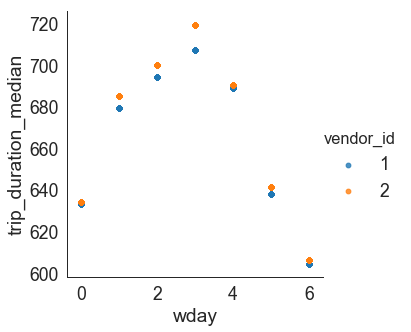

In [82]:
sns.lmplot(y='trip_duration_median', x='wday',data=df_train, fit_reg=False, hue='vendor_id')

Median hourly duration per vender

In [83]:
m = df_train.groupby(['pu_hour','vendor_id'])[['trip_duration']].apply(np.median)
m.name ='trip_duration_median_hour'
df_train = df_train.join(m, on=['pu_hour','vendor_id'])

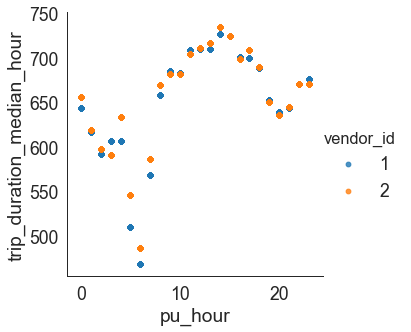

In [84]:
sns.lmplot(y='trip_duration_median_hour', x='pu_hour',data=df_train, fit_reg=False, hue='vendor_id')


In [85]:
jfk_lon = -73.778889
jfk_lat = 40.639722
lga_lon = -73.872611
lga_lat = 40.77725

Distance of pickup and drop from JFK and LGA

In [86]:
df_train['jfk_pickup_dist'] = df_train.apply(lambda row: haversine(jfk_lon, jfk_lat, row['pickup_longitude'],row['pickup_latitude']), axis=1)

In [87]:
df_train['lga_pickup_dist'] = df_train.apply(lambda row: haversine(lga_lon, lga_lat, row['pickup_longitude'],row['pickup_latitude']), axis=1)

In [88]:
df_train['jfk_dropoff_dist'] = df_train.apply(lambda row: haversine(jfk_lon, jfk_lat, row['dropoff_longitude'],row['dropoff_latitude']), axis=1)

In [89]:
df_train['lga_dropoff_dist'] = df_train.apply(lambda row: haversine(lga_lon, lga_lat, row['dropoff_longitude'],row['dropoff_latitude']), axis=1)

distance distribution from jfk and lga

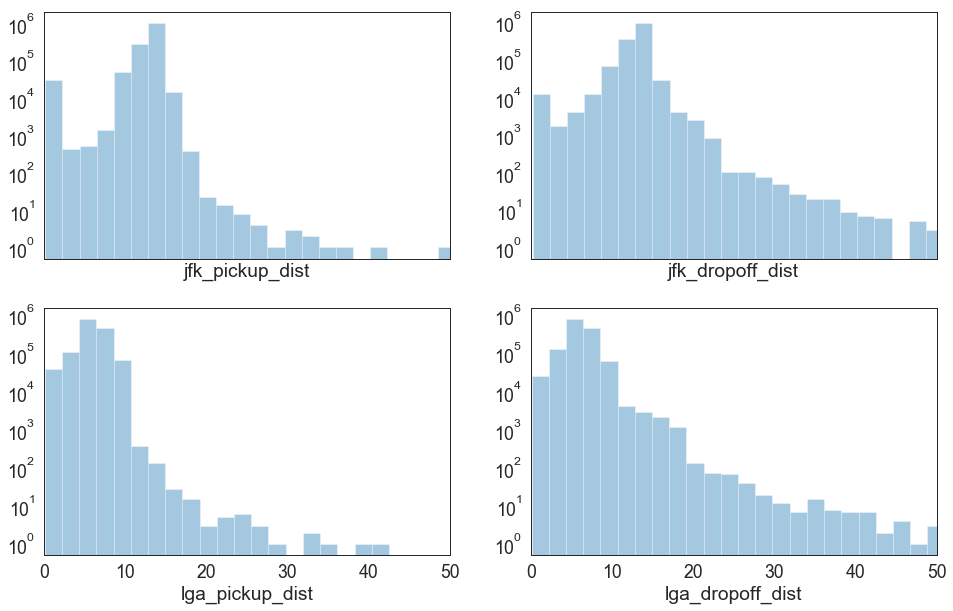

In [90]:
fig, ax = plt.subplots(ncols=2, nrows=2, sharex=True)
ax[0,0].set_xlim(0,50)

sns.distplot(df_train['jfk_pickup_dist'],ax=ax[0,0],bins=100,kde=False,hist_kws={'log':True})
sns.distplot(df_train['jfk_dropoff_dist'],ax=ax[0,1],bins=100,kde=False,hist_kws={'log':True})
sns.distplot(df_train['lga_pickup_dist'],ax=ax[1,0],bins=100,kde=False,hist_kws={'log':True})
sns.distplot(df_train['lga_dropoff_dist'],ax=ax[1,1],bins=100,kde=False,hist_kws={'log':True})

If distance is less than 2 miles from airport then assume it is an airport pick up or drop

In [91]:
df_train['jfk'] = ((df_train['jfk_pickup_dist'] < 2) | (df_train['jfk_dropoff_dist'] < 2))
df_train['lga'] = ((df_train['lga_pickup_dist'] < 2) | (df_train['lga_dropoff_dist'] < 2))
df_train = df_train.drop(['jfk_pickup_dist','lga_pickup_dist','jfk_dropoff_dist','lga_dropoff_dist'],axis=1)
df_train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,snow fall,snow depth,snowfall,snowdepth,total_distance,total_travel_time,trip_duration_median,trip_duration_median_hour,jfk,lga
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,...,0.0,0,0.0,0.0,2009.1,164.9,634.0,709.0,False,False
1,id2129090,1,2016-03-14 14:05:39,2016-03-14 14:28:05,1,-73.975090,40.758766,-73.953201,40.765068,N,...,0.0,0,0.0,0.0,2782.9,244.6,633.0,727.0,False,False
2,id0256505,1,2016-03-14 15:04:38,2016-03-14 15:16:13,1,-73.994484,40.745087,-73.998993,40.722710,N,...,0.0,0,0.0,0.0,3124.4,419.9,633.0,724.0,False,False
3,id3863815,2,2016-03-14 04:24:36,2016-03-14 04:37:11,3,-73.944359,40.714489,-73.910530,40.709492,N,...,0.0,0,0.0,0.0,3327.8,280.8,634.0,633.5,False,False
4,id3817493,2,2016-03-14 14:57:56,2016-03-14 15:15:26,1,-73.952881,40.766468,-73.978630,40.761921,N,...,0.0,0,0.0,0.0,3354.8,270.3,634.0,735.0,False,False


If somebody is picking up cab after 8 and before 18, then most probably using the cab for work related activity

In [92]:
df_train['workday'] = ((df_train['pu_hour'] > 8) & (df_train['pu_hour'] < 18))
df_train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,snow depth,snowfall,snowdepth,total_distance,total_travel_time,trip_duration_median,trip_duration_median_hour,jfk,lga,workday
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,...,0,0.0,0.0,2009.1,164.9,634.0,709.0,False,False,True
1,id2129090,1,2016-03-14 14:05:39,2016-03-14 14:28:05,1,-73.975090,40.758766,-73.953201,40.765068,N,...,0,0.0,0.0,2782.9,244.6,633.0,727.0,False,False,True
2,id0256505,1,2016-03-14 15:04:38,2016-03-14 15:16:13,1,-73.994484,40.745087,-73.998993,40.722710,N,...,0,0.0,0.0,3124.4,419.9,633.0,724.0,False,False,True
3,id3863815,2,2016-03-14 04:24:36,2016-03-14 04:37:11,3,-73.944359,40.714489,-73.910530,40.709492,N,...,0,0.0,0.0,3327.8,280.8,634.0,633.5,False,False,False
4,id3817493,2,2016-03-14 14:57:56,2016-03-14 15:15:26,1,-73.952881,40.766468,-73.978630,40.761921,N,...,0,0.0,0.0,3354.8,270.3,634.0,735.0,False,False,True


ploting map based on pickup longitude and latitude

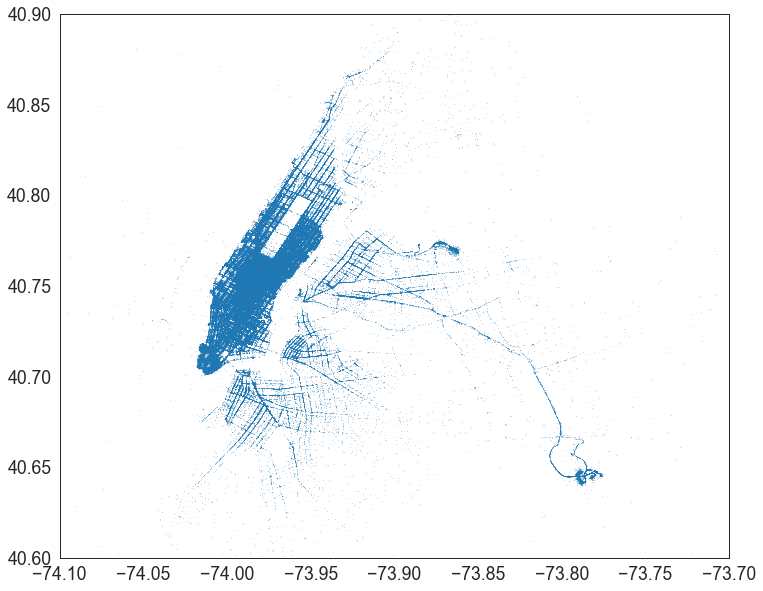

In [93]:
fig, ax = plt.subplots(ncols=1, nrows=1,figsize=(12,10))
plt.ylim(40.6, 40.9)
plt.xlim(-74.1,-73.7)
ax.scatter(df_train['pickup_longitude'],df_train['pickup_latitude'], s=0.01, alpha=1)

## RMSLE: Evaluation Metric

Evaluation Metric .. which is calculating error square

In [95]:
def rmsle(evaluator,X,real):
    sum = 0.0
    predicted = evaluator.predict(X)
    print("Number predicted less than 0: {}".format(np.where(predicted < 0)[0].shape))

    predicted[predicted < 0] = 0
    for x in range(len(predicted)):
        p = np.log(predicted[x]+1)
        r = np.log(real[x]+1)
        sum = sum + (p-r)**2
    return (sum/len(predicted))**0.5

Preapring Test data

In [94]:
tdf = pd.read_csv('test.csv')
tdf.pickup_datetime=pd.to_datetime(tdf.pickup_datetime)
#tdf.dropoff_datetime=pd.to_datetime(tdf.dropoff_datetime)
tdf['pu_hour'] = tdf.pickup_datetime.dt.hour
tdf['yday'] = tdf.pickup_datetime.dt.dayofyear
tdf['wday'] = tdf.pickup_datetime.dt.dayofweek
tdf['month'] = tdf.pickup_datetime.dt.month
tdf['distance'] = haversine(tdf.pickup_longitude, tdf.pickup_latitude,
                                           tdf.dropoff_longitude, tdf.dropoff_latitude)
fastest_test = pd.read_csv('fastest_routes_test.csv')
tdf = pd.merge(tdf,fastest_test,on='id',how='outer')
tdf = tdf.drop(['step_location_list','step_direction','step_maneuvers','travel_time_per_step','distance_per_step','street_for_each_step','number_of_steps','starting_street','end_street'],axis=1)
tdf = pd.merge(tdf,wdf,on='yday')
tdf = tdf.drop(['date','maximum temperature','minimum temperature'],axis=1)
tdf['jfk_pickup_dist'] = tdf.apply(lambda row: haversine(jfk_lon, jfk_lat, row['pickup_longitude'],row['pickup_latitude']), axis=1)
tdf['lga_pickup_dist'] = tdf.apply(lambda row: haversine(lga_lon, lga_lat, row['pickup_longitude'],row['pickup_latitude']), axis=1)
tdf['jfk_dropoff_dist'] = tdf.apply(lambda row: haversine(jfk_lon, jfk_lat, row['dropoff_longitude'],row['dropoff_latitude']), axis=1)
tdf['lga_dropoff_dist'] = tdf.apply(lambda row: haversine(lga_lon, lga_lat, row['dropoff_longitude'],row['dropoff_latitude']), axis=1)
tdf['jfk'] = ((tdf['jfk_pickup_dist'] < 2) | (tdf['jfk_dropoff_dist'] < 2))
tdf['lga'] = ((tdf['lga_pickup_dist'] < 2) | (tdf['lga_dropoff_dist'] < 2))
tdf = tdf.drop(['jfk_pickup_dist','lga_pickup_dist','jfk_dropoff_dist','lga_dropoff_dist'],axis=1)
tdf['workday'] = ((tdf['pu_hour'] > 8) & (tdf['pu_hour'] < 18))

In [96]:
tdf['snowfall'] = tdf['snow fall'].replace(['T'],0.05)
tdf['precipitation'] = tdf['precipitation'].replace(['T'],0.05)
tdf['snowdepth'] = tdf['snow depth'].replace(['T'],0.05)

In [97]:
tdf.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,pu_hour,...,total_travel_time,average temperature,precipitation,snow fall,snow depth,snowfall,snowdepth,jfk,lga,workday
0,id3004672,1,2016-06-30 23:59:58,1,-73.988129,40.732029,-73.990173,40.756680,N,23,...,424.6,76.0,0.0,0.0,0,0.0,0,False,False,False
1,id3505355,1,2016-06-30 23:59:53,1,-73.964203,40.679993,-73.959808,40.655403,N,23,...,200.0,76.0,0.0,0.0,0,0.0,0,False,False,False
2,id1217141,1,2016-06-30 23:59:47,1,-73.997437,40.737583,-73.986160,40.729523,N,23,...,193.2,76.0,0.0,0.0,0,0.0,0,False,False,False
3,id2150126,2,2016-06-30 23:59:41,1,-73.956070,40.771900,-73.986427,40.730469,N,23,...,494.8,76.0,0.0,0.0,0,0.0,0,False,False,False
4,id1598245,1,2016-06-30 23:59:33,1,-73.970215,40.761475,-73.961510,40.755890,N,23,...,103.2,76.0,0.0,0.0,0,0.0,0,False,False,False


In [98]:
df_train.to_csv('train_data.csv',index=False)
tdf.to_csv('test_data.csv',index=False)

In [99]:
df = pd.read_csv('train_data.csv')

/home/dheeraj/work/env1/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [100]:
tdf = pd.read_csv('test_data.csv')

/home/dheeraj/work/env1/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [101]:
benchmark = fastest_test[['id','total_travel_time']]
benchmark = benchmark.rename(index=str, columns={"total_travel_time": "trip_duration"})
benchmark.head()

,id,trip_duration
0,id0771704,200.2
1,id3274209,141.5
2,id2756455,324.6
3,id3684027,84.2
4,id3101285,294.7


In [102]:
benchmark['trip_duration'].isnull().values.any()
benchmark.to_csv('benchmark.csv',index=False)
#RMSLE=0.990

Define our features and target

In [103]:
features = df[['vendor_id','passenger_count','pickup_latitude','pickup_longitude','dropoff_latitude','dropoff_longitude','pu_hour','wday','month','workday','precipitation','snowfall','snowdepth','total_distance','total_travel_time','jfk','lga']]
target = df['trip_duration']

In [104]:
tfeatures = tdf[['vendor_id','passenger_count','pickup_latitude','pickup_longitude','dropoff_latitude','dropoff_longitude','pu_hour','wday','month','workday','precipitation','snowfall','snowdepth','total_distance','total_travel_time','jfk','lga']]

### Linear Regression

Start with lindear regression

will also use cross validation http://scikit-learn.org/stable/modules/cross_validation.html
http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html


In [116]:
from sklearn import linear_model

reg = linear_model.LinearRegression()
cv = ShuffleSplit(n_splits=4, test_size=0.1, random_state=0)
rmsle_scores = cross_val_score(reg, features, np.ravel(target), cv=cv, scoring=rmsle)
print(rmsle_scores)
print(np.mean(rmsle_scores))
reg.fit(features, target)
# scoring.head()

Number predicted less than 0: (14,)
Number predicted less than 0: (9,)
Number predicted less than 0: (17,)
Number predicted less than 0: (12,)
[0.43999629 0.44022777 0.43897461 0.44073686]
0.43998388024617663


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

#RMSLE=43998388024617663

In [106]:
np.mean([0.43999629, 0.44022777, 0.43897461, 0.44073686])

0.4399838825

In [107]:
tfeatures.shape

(625134, 17)

In [108]:
pred = reg.predict(tfeatures)
print(np.where(pred < 0)[0].shape)
pred[pred < 0]=0

(490,)


In [109]:
tdf['trip_duration']=pred.astype(int)
out = tdf[['id','trip_duration']]

In [110]:
out['trip_duration'].isnull().values.any()

False

In [117]:
out.to_csv('pred_linear.csv',index=False)

## K-nearest Neighbors Regression


In [155]:
from sklearn.neighbors import KNeighborsRegressor
neigh = KNeighborsRegressor(n_neighbors=10)
cv = ShuffleSplit(n_splits=4, test_size=0.1, random_state=0)
rmse_knn_scores = cross_val_score(neigh, features, np.ravel(target), cv=cv,scoring=rmsle)
print(rmse_knn_scores)
print(np.mean(rmse_knn_scores))
neigh.fit(features,target)

Number predicted less than 0: (0,)
Number predicted less than 0: (0,)
Number predicted less than 0: (0,)
Number predicted less than 0: (0,)
[0.42011203 0.4194096  0.41947696 0.41968832]
0.4196717298480179


KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=10, p=2,
          weights='uniform')

RMSE 0.4196717298480179

In [156]:
pred = neigh.predict(tfeatures)
print(np.where(pred < 0)[0].shape)

(0,)


In [157]:
tdf['trip_duration']=pred.astype(int)
out = tdf[['id','trip_duration']]
out.to_csv('pred_knn.csv',index=False)

In [130]:
tdf.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,pu_hour,...,average temperature,precipitation,snow fall,snow depth,snowfall,snowdepth,jfk,lga,workday,trip_duration
0,id3004672,1,2016-06-30 23:59:58,1,-73.988129,40.732029,-73.990173,40.756680,N,23,...,76.0,0.0,0,0,0.0,0.0,False,False,False,821
1,id3505355,1,2016-06-30 23:59:53,1,-73.964203,40.679993,-73.959808,40.655403,N,23,...,76.0,0.0,0,0,0.0,0.0,False,False,False,669
2,id1217141,1,2016-06-30 23:59:47,1,-73.997437,40.737583,-73.986160,40.729523,N,23,...,76.0,0.0,0,0,0.0,0.0,False,False,False,516
3,id2150126,2,2016-06-30 23:59:41,1,-73.956070,40.771900,-73.986427,40.730469,N,23,...,76.0,0.0,0,0,0.0,0.0,False,False,False,999
4,id1598245,1,2016-06-30 23:59:33,1,-73.970215,40.761475,-73.961510,40.755890,N,23,...,76.0,0.0,0,0,0.0,0.0,False,False,False,320


In [151]:
tdf['trip_duration'][2]

516

In [132]:
out.head()

,id,trip_duration
0,id3004672,821
1,id3505355,669
2,id1217141,516
3,id2150126,999
4,id1598245,320


In [134]:
benchmark.head()

,id,trip_duration
0,id0771704,200.2
1,id3274209,141.5
2,id2756455,324.6
3,id3684027,84.2
4,id3101285,294.7


In [153]:
benchmark[benchmark['id'] == "id1598245"]['trip_duration'].values

array([103.2])

## Random Forest

In [159]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor()
cv = ShuffleSplit(n_splits=4, test_size=0.1, random_state=0)
print(cross_val_score(rf, features, np.ravel(target), cv=cv,scoring=rmsle))
rf = rf.fit(features,np.ravel(target))

/home/dheeraj/work/env1/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


Number predicted less than 0: (0,)
Number predicted less than 0: (0,)
Number predicted less than 0: (0,)
Number predicted less than 0: (0,)
[0.35189087 0.34951766 0.35026937 0.3502337 ]


In [162]:
np.mean([0.35189087,0.34951766,0.35026937,0.3502337])

0.3504779

In [160]:
pred = rf.predict(tfeatures)
print(np.where(pred < 0)[0].shape)

(0,)


In [161]:
tdf['trip_duration']=pred.astype(int)
out = tdf[['id','trip_duration']]
out.to_csv('pred_rf.csv',index=False)

## XGBoost

In [163]:
reg = xgboost.XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75,
                           colsample_bytree=1, max_depth=7)

cv = ShuffleSplit(n_splits=4, test_size=0.1, random_state=0)
print(cross_val_score(reg, features, np.ravel(target), cv=cv,scoring=rmsle))
reg.fit(features,target)

Number predicted less than 0: (1,)
Number predicted less than 0: (0,)
Number predicted less than 0: (0,)
Number predicted less than 0: (0,)
[0.34347665 0.34339981 0.34196098 0.34286028]


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.08, max_delta_step=0,
       max_depth=7, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.75)

In [164]:
np.mean([0.34347665, 0.34339981, 0.34196098, 0.34286028])

0.34292443

In [165]:
pred = reg.predict(tfeatures)
print(np.where(pred < 0)[0].shape)

(0,)


In [166]:
pred[pred < 0] = 0
tdf['trip_duration']=pred.astype(int)
out = tdf[['id','trip_duration']]
out['trip_duration'].isnull().values.any()
out.to_csv('pred_xgboost.csv',index=False)

In [168]:
import pickle
pickle.dump(reg, open('xgb_model.sav','wb'),protocol=2)